In [1]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns


from keras.utils import array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential, layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import Precision, Recall

from sklearn.model_selection import train_test_split

2025-12-02 09:58:39.482174: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-02 09:58:39.927781: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-02 09:58:40.107213: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-12-02 09:58:40.107266: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

# 1.Load Dataset

In [2]:
data_dir = "/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/"


In [3]:
img = load_img(f"{data_dir}notumor/Tr-no_0010.jpg")
x = img_to_array(img)/255  # We divide the pixel value by 255 to end up between 0 and 1

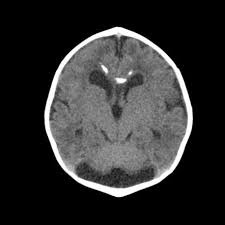

In [4]:
img

In [5]:
x.shape

(225, 225, 3)

## 1.1 Dataframe creation with images paths and label



In [6]:
def path_df(tr_path):
    classes = []
    class_paths = []

    for label in os.listdir(tr_path):
        folder = os.path.join(tr_path, label)
        if os.path.isdir(folder):
            for image in os.listdir(folder):
                classes.append(label)
                class_paths.append(os.path.join(folder, image))

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df


In [7]:
df = path_df(data_dir)

In [8]:
df


,Class Path,Class
0,/home/aurore/code/afallo/brain_tumor_detection...,tumor
1,/home/aurore/code/afallo/brain_tumor_detection...,tumor
2,/home/aurore/code/afallo/brain_tumor_detection...,tumor
3,/home/aurore/code/afallo/brain_tumor_detection...,tumor
4,/home/aurore/code/afallo/brain_tumor_detection...,tumor
...,...,...
19179,/home/aurore/code/afallo/brain_tumor_detection...,notumor
19180,/home/aurore/code/afallo/brain_tumor_detection...,notumor
19181,/home/aurore/code/afallo/brain_tumor_detection...,notumor
19182,/home/aurore/code/afallo/brain_tumor_detection...,notumor


In [10]:
!pip install ImageHash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 8.1 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [ImageHash]]


In [ ]:
import pandas as pd
from PIL import Image
import imagehash

# Exemple : ton DataFrame contient une colonne 'path'
# df = pd.DataFrame({"path": ["img1.jpg", "img2.jpg", ...]})

def compute_phash(img_path):
    try:
        img = Image.open(img_path)
        return imagehash.phash(img)
    except Exception as e:
        #print(f"Erreur avec {img_path}: {e}")
        return None

# Calcul du pHash pour chaque image
df["phash"] = df["Class Path"].apply(compute_phash)

# Détection des duplicats exacts (même hash)
duplicates = df[df.duplicated("phash", keep=False)].sort_values("phash")

print("Duplicats détectés :")
print(duplicates)

# Détection des quasi-duplicats (distance de Hamming < seuil)
def is_near_duplicate(hash1, hash2, threshold=5):
    if hash1 is None or hash2 is None:
        return False
    return abs(hash1 - hash2) < threshold

# Exemple : comparer toutes les paires (attention O(n^2), à optimiser si dataset gros)
near_duplicates = []
paths = df["Class Path"].tolist()
hashes = df["phash"].tolist()

for i in range(len(paths)):
    for j in range(i+1, len(paths)):
        if is_near_duplicate(hashes[i], hashes[j], threshold=5):
            near_duplicates.append((paths[i], paths[j]))

print("Quasi-duplicats détectés :")
for dup in near_duplicates:
    print(dup)

Erreur avec /home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Tr-gl_0566.jpg:Zone.Identifier: cannot identify image file '/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Tr-gl_0566.jpg:Zone.Identifier'
Erreur avec /home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Te-me_0073.jpg:Zone.Identifier: cannot identify image file '/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Te-me_0073.jpg:Zone.Identifier'
Erreur avec /home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Tr-pi_0650.jpg:Zone.Identifier: cannot identify image file '/home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Tr-pi_0650.jpg:Zone.Identifier'
Erreur avec /home/aurore/code/afallo/brain_tumor_detection_project/raw_data/classification_binaire/tumor/Te-pi_0271.jpg:Zone.Ident

TypeError: '<' not supported between instances of 'ImageHash' and 'ImageHash'

# 2.Train val test split

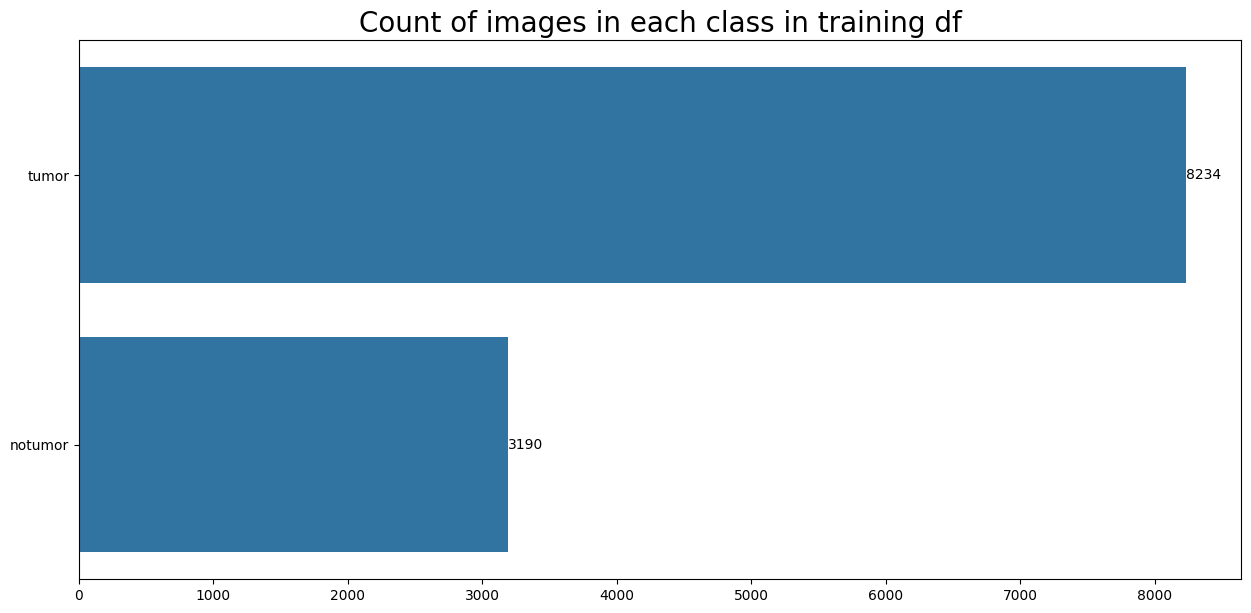

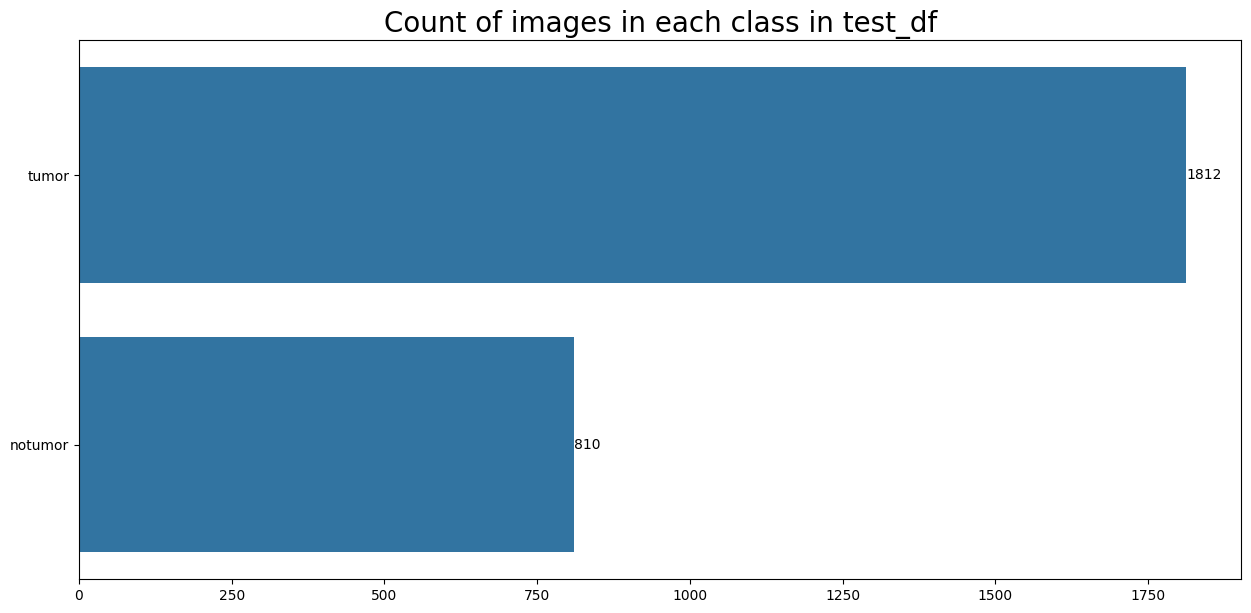

In [124]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=training_df , y=training_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in training df', fontsize=20)
ax.bar_label(ax.containers[0])

plt.figure(figsize=(15,7))
ax = sns.countplot(data=test_df , y=test_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class in test_df', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

In [125]:
val_df, train_df = train_test_split(training_df, train_size=0.3, random_state=20, stratify=training_df['Class'])

# 3.Preprocess

In [152]:
batch_size = 32
img_size = (225, 225)

scale = ImageDataGenerator(rescale=1/255)
scale_gen = ImageDataGenerator(rescale=1/255, brightness_range=(0.8,1.2))

train_scale_gen = scale_gen.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

train_scale = scale.flow_from_dataframe(train_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary")

val_scale_gen = scale_gen.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")


val_scale = scale.flow_from_dataframe(val_df, x_col='Class Path',
                                     y_col='Class', batch_size=batch_size,
                                     target_size=img_size, class_mode="binary")

test_scale = scale.flow_from_dataframe(test_df, x_col='Class Path',
                                  y_col='Class', batch_size=batch_size,
                                  target_size=img_size, class_mode="binary", shuffle = False)

Found 4001 validated image filenames belonging to 2 classes.
Found 4001 validated image filenames belonging to 2 classes.
Found 1711 validated image filenames belonging to 2 classes.
Found 1711 validated image filenames belonging to 2 classes.
Found 1311 validated image filenames belonging to 2 classes.


/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3996 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 3996 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1716 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/image.py:1139: UserWarning: Found 1716 invalid image filename(s) in x_col="Class Path". These filename(s) will be ignored.
  warnings.warn(
/home/aurore/.pyenv/versions/brain-env/lib/python3.10/site-packages/keras/preprocessing/

In [127]:
len(train_df)

7997

# 4.Base Model

In [165]:
def initialize_model():

    model = Sequential()
    model.add(Input(shape=(225, 225, 3)))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(8, (4, 4), padding ='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    ### Second Convolution & MaxPooling
    #model.add(layers.Conv2D(16, (3, 3), activation="relu"))
    #model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(5, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(1, activation='sigmoid'))

    ### Model compilation
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Recall(), Precision()])
    return model

In [166]:
model = initialize_model()
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 225, 225, 8)       392       
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 112, 112, 8)      0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 100352)            0         
                                                                 
 dense_28 (Dense)            (None, 5)                 501765    
                                                                 
 dense_29 (Dense)            (None, 1)                 6         
                                                                 
Total params: 502,163
Trainable params: 502,163
Non-trainable params: 0
_______________________________________________

In [167]:
es = EarlyStopping(patience = 2, restore_best_weights=True )
history = model.fit(train_scale_gen,
                 epochs=20,
                 validation_data=val_scale,
                 callbacks = [es])

Epoch 1/20
126/126 [==============================] - 15s 116ms/step - loss: 0.7200 - accuracy: 0.7116 - recall: 0.9819 - precision: 0.7195 - val_loss: 0.6727 - val_accuracy: 0.7241 - val_recall: 1.0000 - val_precision: 0.7241
Epoch 2/20
126/126 [==============================] - 12s 93ms/step - loss: 0.6636 - accuracy: 0.7193 - recall: 1.0000 - precision: 0.7193 - val_loss: 0.6534 - val_accuracy: 0.7241 - val_recall: 1.0000 - val_precision: 0.7241
Epoch 3/20
126/126 [==============================] - 12s 96ms/step - loss: 0.6470 - accuracy: 0.7193 - recall: 1.0000 - precision: 0.7193 - val_loss: 0.6386 - val_accuracy: 0.7241 - val_recall: 1.0000 - val_precision: 0.7241
Epoch 4/20
126/126 [==============================] - 13s 99ms/step - loss: 0.6338 - accuracy: 0.7193 - recall: 1.0000 - precision: 0.7193 - val_loss: 0.6260 - val_accuracy: 0.7241 - val_recall: 1.0000 - val_precision: 0.7241
Epoch 5/20
126/126 [==============================] - 11s 90ms/step - loss: 0.6231 - accuracy: 

In [179]:
def plot_history(history):

    fig, ax = plt.subplots(4, 1, figsize=(5,13))

    ax[0].set_title('loss')

    ax[0].plot(history.epoch, history.history["loss"], label="Train loss")
    ax[0].plot(history.epoch, history.history["val_loss"], label="Validation loss")

    ax[1].set_title('Accuracy')

    ax[1].plot(history.epoch, history.history["accuracy"], label="Train Accuracy")
    ax[1].plot(history.epoch, history.history["val_accuracy"], label="Validation Accuracy")


    ax[2].set_title('Recall')

    ax[2].plot(history.epoch, history.history["recall"], label="Train recall")
    ax[2].plot(history.epoch, history.history["val_recall"], label="Validation recall")

    ax[3].set_title('Precision')

    ax[3].plot(history.epoch, history.history["precision"], label="precision")
    ax[3].plot(history.epoch, history.history["val_precision"], label="Validation precision")


    ax[0].legend()
    ax[1].legend()
    ax[2].legend()
    ax[3].legend()

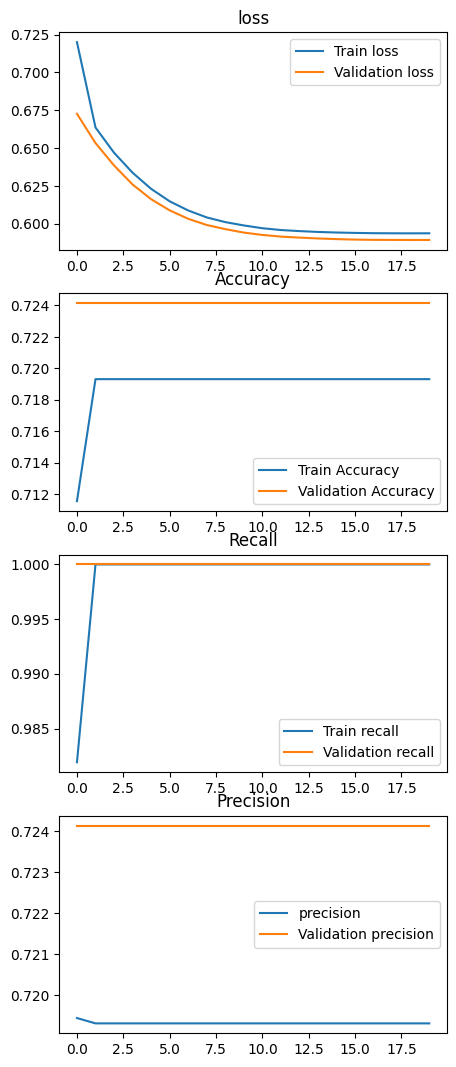

In [180]:

plot_history(history)


In [156]:
model.evaluate(test_scale)

41/41 [==============================] - 2s 39ms/step - loss: 0.1322 - accuracy: 0.9672


[0.13224825263023376, 0.9672006368637085]